# CSE6250BDH Deep Learning Labs
## 3. Recurrent Neural Network (Part 1)

In this chapter, we will learn how to implement a recurrent neural network by using PyTorch.

#### 0. Prepare Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('data.csv')
labels = df['y'].as_matrix()
labels = labels - 1
data = df.loc[:, 'X1':'X178'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

#### 1. Loading Datasets
Shape of input tensor is (batch, seq_len, input_size), different from the one used for CNN in the previous chapter.

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset

trainset = TensorDataset(torch.from_numpy(X_train.astype('float32')).unsqueeze(2), torch.from_numpy(y_train.astype('long')))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True, num_workers=2)

validset = TensorDataset(torch.from_numpy(X_valid.astype('float32')).unsqueeze(2), torch.from_numpy(y_valid.astype('long')))
validloader = torch.utils.data.DataLoader(validset, batch_size=10, shuffle=False, num_workers=2)

testset = TensorDataset(torch.from_numpy(X_test.astype('float32')).unsqueeze(2), torch.from_numpy(y_test.astype('long')))
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False, num_workers=2)

classes = ('Seizure', 'TumorArea', 'HealthyArea', 'EyesClosed', 'EyesOpen')

#### 2. Define RNN class

In [3]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=32, num_layers=2, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(in_features=32, out_features=5)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = F.tanh(x[:, -1, :])
        x = self.fc(x)
        return x


model = RecurNet()

#### 3. Define a Loss function and optimizer

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

#### 4. Train the network

In [6]:
cuda = torch.cuda.is_available()
if cuda:
    model = model.cuda()

train_losses = []
valid_losses = []

for epoch in range(15):  # loop over the dataset multiple times

    # set the model as train mode
    model.train()
    train_loss = 0.0
    train_counter = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, targets = data

        # wrap them in Variable
        inputs, targets = Variable(inputs), Variable(targets)
        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += (loss.data[0] * inputs.size(0))
        train_counter += inputs.size(0)

    train_losses.append(train_loss/train_counter)
    
    # switch to evaluation mode
    model.eval()
    valid_loss = 0.0
    valid_counter = 0
    for i, data in enumerate(validloader, 0):
        # get the inputs
        inputs, targets = data

        # wrap them in Variable
        inputs, targets = Variable(inputs, volatile=True), Variable(targets, volatile=True)
        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        valid_loss += (loss.data[0] * inputs.size(0))
        valid_counter += inputs.size(0)
    valid_losses.append(valid_loss/valid_counter)
    
print('Finished Training')

Finished Training


#### 5. Test the network on the test data

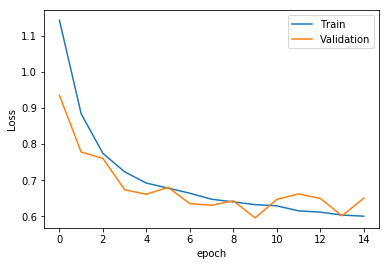

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(valid_losses)), valid_losses, label='Validation')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc="best")

In [8]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
for data in testloader:
    # get the inputs
    inputs, targets = data

    # wrap them in Variable
    inputs = Variable(inputs, volatile=True)
    if cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == targets).squeeze()
    for i, label in enumerate(targets):
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(len(classes)):
    print('Accuracy of %s : %2d%% out of %d cases' % (classes[i], 100 * class_correct[i] / class_total[i], class_total[i]))

Accuracy of Seizure : 90% out of 454 cases
Accuracy of TumorArea : 40% out of 477 cases
Accuracy of HealthyArea : 54% out of 472 cases
Accuracy of EyesClosed : 66% out of 422 cases
Accuracy of EyesOpen : 92% out of 475 cases


### Excersize 1. Try to use different type of RNN cell (e.g. LSTM)

### Excersize 2. How do you compare the result with the previous chapter? What about computation time?